In [7]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [8]:
transcript['person'].nunique()

17000

In [9]:
model_data_labels = transcript[transcript['event'] == 'offer received'][['person','value','time']].reset_index(drop = True)

In [10]:
model_data_labels['offer_id'] = model_data_labels['value'].apply(lambda x: x.get('offer id'))
model_data_labels['label'] = 0
model_data_labels = model_data_labels.drop('value',axis = 1)

In [11]:
model_data_labels['person'].nunique()

16994

In [12]:
model_data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 4 columns):
person      76277 non-null object
time        76277 non-null int64
offer_id    76277 non-null object
label       76277 non-null int64
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [13]:
model_data_labels[['person','offer_id']].drop_duplicates().count()

person      63288
offer_id    63288
dtype: int64

In [14]:
portfolio.rename(columns = {'id' : 'offer_id'},inplace = True)
model_data_labels = pd.merge(model_data_labels,portfolio[['offer_id','duration']],on = 'offer_id')

In [15]:
model_data_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 5 columns):
person      76277 non-null object
time        76277 non-null int64
offer_id    76277 non-null object
label       76277 non-null int64
duration    76277 non-null int64
dtypes: int64(3), object(2)
memory usage: 3.5+ MB


In [16]:
offer_viewed = transcript[transcript['event'] == 'offer viewed'][['person','value','time']].copy().reset_index(drop = True)
offer_completed= transcript[transcript['event'] == 'offer completed'][['person','value','time']].copy().reset_index(drop = True)
offer_viewed['offer_id'] = offer_viewed['value'].apply(lambda x: x.get('offer id'))
offer_completed['offer_id'] = offer_completed['value'].apply(lambda x: x.get('offer_id'))

In [17]:
offer_completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33579 entries, 0 to 33578
Data columns (total 4 columns):
person      33579 non-null object
value       33579 non-null object
time        33579 non-null int64
offer_id    33579 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [18]:
offer_viewed_completed = pd.merge(offer_viewed[['person','offer_id','time']],
                                  offer_completed[['person','offer_id','time']],on = ['person','offer_id'])

In [19]:
offer_viewed_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37952 entries, 0 to 37951
Data columns (total 4 columns):
person      37952 non-null object
offer_id    37952 non-null object
time_x      37952 non-null int64
time_y      37952 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [20]:
offer_viewed_completed = offer_viewed_completed[offer_viewed_completed['time_x'] <= offer_viewed_completed['time_y']].copy().reset_index(drop = True)

In [21]:
offer_viewed_completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29098 entries, 0 to 29097
Data columns (total 4 columns):
person      29098 non-null object
offer_id    29098 non-null object
time_x      29098 non-null int64
time_y      29098 non-null int64
dtypes: int64(2), object(2)
memory usage: 909.4+ KB


In [22]:
offer_viewed_completed = offer_viewed_completed.rename(columns = {'person':'person_right','offer_id' : 'offer_id_right'})
model_data_labels_completed = pd.merge(model_data_labels,offer_viewed_completed,how = 'inner',left_on = ['person','offer_id']
                            ,right_on = ['person_right','offer_id_right'])

In [23]:
model_data_labels_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45075 entries, 0 to 45074
Data columns (total 9 columns):
person            45075 non-null object
time              45075 non-null int64
offer_id          45075 non-null object
label             45075 non-null int64
duration          45075 non-null int64
person_right      45075 non-null object
offer_id_right    45075 non-null object
time_x            45075 non-null int64
time_y            45075 non-null int64
dtypes: int64(5), object(4)
memory usage: 3.4+ MB


In [24]:
model_data_labels_completed['time_diff'] = model_data_labels_completed['time_y'] - model_data_labels_completed['time']
model_data_labels_completed = model_data_labels_completed[model_data_labels_completed['time_diff'] <= model_data_labels_completed['duration'] * 24].copy().reset_index(drop = True)

In [25]:
model_data_labels_completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36416 entries, 0 to 36415
Data columns (total 10 columns):
person            36416 non-null object
time              36416 non-null int64
offer_id          36416 non-null object
label             36416 non-null int64
duration          36416 non-null int64
person_right      36416 non-null object
offer_id_right    36416 non-null object
time_x            36416 non-null int64
time_y            36416 non-null int64
time_diff         36416 non-null int64
dtypes: int64(6), object(4)
memory usage: 2.8+ MB


In [26]:
model_data_labels_completed = model_data_labels_completed.groupby(['person','offer_id']
                                                                  ,as_index = False)['time'].min()

In [27]:
model_data_labels_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21372 entries, 0 to 21371
Data columns (total 3 columns):
person      21372 non-null object
offer_id    21372 non-null object
time        21372 non-null int64
dtypes: int64(1), object(2)
memory usage: 667.9+ KB


In [28]:
model_data_labels_completed['label_completed'] = 1
model_data_labels = pd.merge(model_data_labels,model_data_labels_completed,how = 'left',on = ['person','offer_id','time'])

In [29]:
model_data_labels['label'] = np.where(model_data_labels['label_completed'] ==1,1,0)

In [30]:
model_data_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 6 columns):
person             76277 non-null object
time               76277 non-null int64
offer_id           76277 non-null object
label              76277 non-null int64
duration           76277 non-null int64
label_completed    21372 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.1+ MB


In [31]:
model_data_labels0 = model_data_labels[model_data_labels['label'] == 0].copy().reset_index(drop = True)

In [38]:
model_data_labels0_not_completed = model_data_labels0[model_data_labels0['time'] > 714 - 
                                                      model_data_labels0['duration'] * 24].copy()\
                                                                                        .reset_index(drop = True)

In [39]:
model_data_labels0_not_completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 6 columns):
person             7405 non-null object
time               7405 non-null int64
offer_id           7405 non-null object
label              7405 non-null int64
duration           7405 non-null int64
label_completed    0 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 347.2+ KB


In [40]:
model_data_labels0_not_completed.groupby(['person','offer_id'],as_index = False)['time'].count()\
.sort_values(by = 'time',ascending = False)

,person,offer_id,time
1381,3044e3dd3805485e9d39bcda615c6be5,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
1500,345f9431137a49b3963221a55567c4a8,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
2621,5a7136999fa240838c28e52359f6533d,fafdcd668e3743c1bb461111dcafc2a4,2
2417,535966e0a95d45389d4b8e935723b046,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
3523,79904d30eb8a4763b5011a010e53fb97,fafdcd668e3743c1bb461111dcafc2a4,2
5584,c0852430ada44573a218de7c3b92abbe,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
3284,70e89b09554b457598b077139ef10585,fafdcd668e3743c1bb461111dcafc2a4,2
1285,2d59f307fcbf4f4dab5218893231e522,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
2427,53f9276cd0f24fe08a42f99ae60ba2b4,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
2604,5a16683f3bf14ea9aa0b79b0cf8cbf40,0b1e1539f2cc45b7b9fa7c272da2e1d7,2


In [34]:
offer_completed = offer_completed.rename(columns = {'person':'person_right','offer_id' : 'offer_id_right'})
model_data_labels0_not_completed = pd.merge(model_data_labels0_not_completed,
                                            offer_completed,
                                            how = 'inner',
                                            left_on = ['person','offer_id'],
                                            right_on = ['person_right','offer_id_right']
                                           )

In [ ]:
model_data_labels0_not_completed['time_diff'] = model_data_labels0_not_completed['time_y'] - model_data_labels0_not_completed['time']
model_data_labels0_not_completed = model_data_labels0_not_completed[model_data_labels0_not_completed['time_diff'] <= model_data_labels0_not_completed['duration'] * 24].copy().reset_index(drop = True)


In [35]:
model_data_labels0_not_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4633 entries, 0 to 4632
Data columns (total 8 columns):
person             4633 non-null object
time_x             4633 non-null int64
offer_id           4633 non-null object
label              4633 non-null int64
duration           4633 non-null int64
label_completed    0 non-null float64
value              4633 non-null object
time_y             4633 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 325.8+ KB


In [24]:
model_data_labels0_unique = model_data_labels0.groupby(['person','offer_id'],as_index = False)['time'].max()
model_data_labels0_unique['label'] = 0

In [25]:
final_data = pd.concat([model_data_labels0_unique,
                        model_data_labels[model_data_labels['label'] == 1][['person','offer_id','time','label']]],
                       ignore_index = True)

In [26]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68686 entries, 0 to 68685
Data columns (total 4 columns):
person      68686 non-null object
offer_id    68686 non-null object
time        68686 non-null int64
label       68686 non-null int64
dtypes: int64(2), object(2)
memory usage: 2.1+ MB


In [27]:
final_data = final_data.drop_duplicates(subset = ['person','offer_id'],keep = 'last').reset_index(drop = True)

In [28]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63288 entries, 0 to 63287
Data columns (total 4 columns):
person      63288 non-null object
offer_id    63288 non-null object
time        63288 non-null int64
label       63288 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


In [29]:
#offer exploration
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
portfolio['number_channels'] = portfolio['channels'].apply(lambda x: len(x))

In [32]:
final_data = pd.merge(final_data,portfolio,on = 'offer_id',how = 'left')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 10 columns):
person             63288 non-null object
offer_id           63288 non-null object
time               63288 non-null int64
label              63288 non-null int64
channels           63288 non-null object
difficulty         63288 non-null int64
duration           63288 non-null int64
offer_type         63288 non-null object
reward             63288 non-null int64
number_channels    63288 non-null int64
dtypes: int64(6), object(4)
memory usage: 5.3+ MB


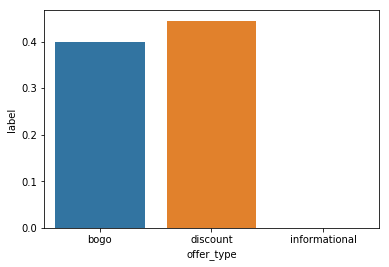

In [33]:
offer_type_data = final_data.groupby('offer_type',as_index = False)['label'].mean()
sns.barplot(data = offer_type_data,x='offer_type',y='label')

In [34]:
final_data['offer_type'].value_counts()

bogo             25321
discount         25316
informational    12651
Name: offer_type, dtype: int64

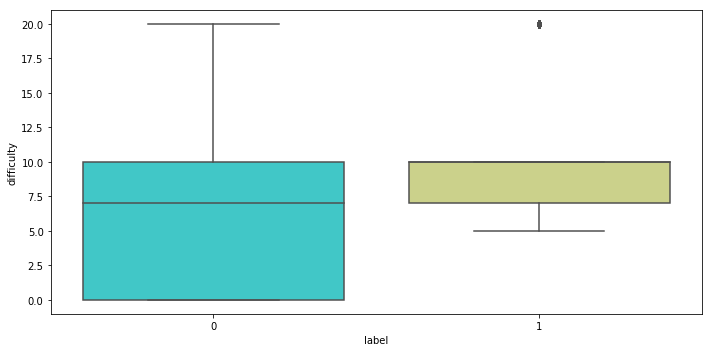

In [35]:
fig,axes=plt.subplots(figsize=(10,5))
sns.boxplot(data=final_data,x='label',y='difficulty',palette='rainbow')
plt.tight_layout()

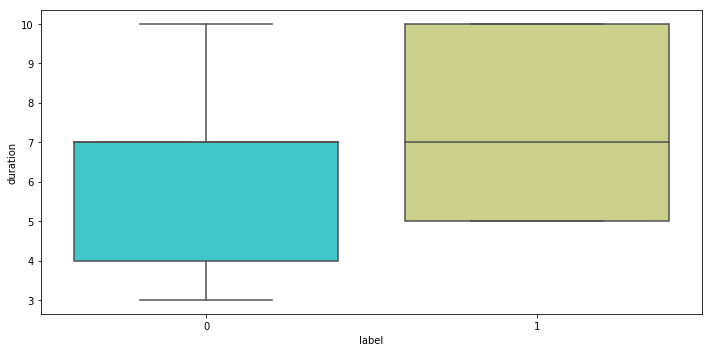

In [36]:
fig,axes=plt.subplots(figsize=(10,5))
sns.boxplot(data=final_data,x='label',y='duration',palette='rainbow')
plt.tight_layout()

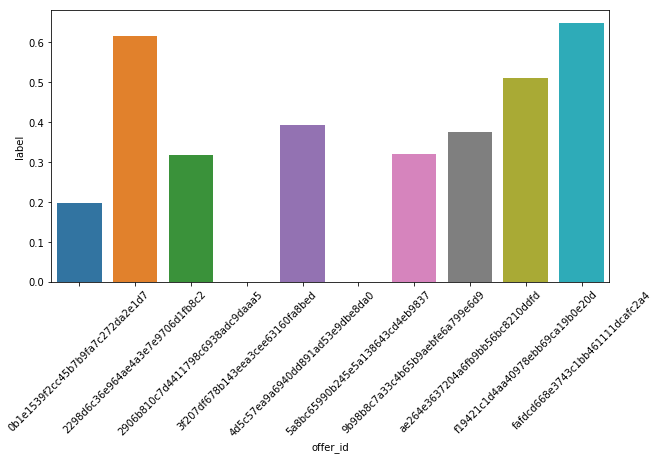

In [37]:
fig,axes=plt.subplots(figsize=(10,5))
offer_type_data = final_data.groupby('offer_id',as_index = False)['label'].mean()
plt.xticks(rotation=45)
sns.barplot(data = offer_type_data,x='offer_id',y='label')

In [38]:
offer_type_data

,offer_id,label
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.198149
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.615968
2,2906b810c7d4411798c6938adc9daaa5,0.318059
3,3f207df678b143eea3cee63160fa8bed,0.000000
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.392259
5,5a8bc65990b245e5a138643cd4eb9837,0.000000
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.319748
7,ae264e3637204a6fb9bb56bc8210ddfd,0.375431
8,f19421c1d4aa40978ebb69ca19b0e20d,0.511817
9,fafdcd668e3743c1bb461111dcafc2a4,0.647663


In [39]:
portfolio[portfolio['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4']

,channels,difficulty,duration,offer_id,offer_type,reward,number_channels
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,4


In [40]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward,number_channels
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,3
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,4
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,3
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,3
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,2
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,4
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,4
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,3
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,4
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,3


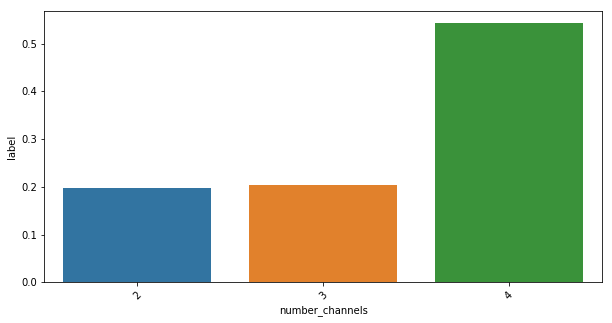

In [41]:
fig,axes=plt.subplots(figsize=(10,5))
offer_type_data = final_data.groupby('number_channels',as_index = False)['label'].mean()
plt.xticks(rotation=45)
sns.barplot(data = offer_type_data,x='number_channels',y='label')

In [42]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [43]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [44]:
profile = profile.rename(columns = {'id':'person'})

In [45]:
profile[profile['gender'] == 'O']

,age,became_member_on,gender,person,income
31,53,20170916,O,d1ede868e29245ea91818a903fec04c6,52000.0
273,60,20180216,O,d0be9ff460964c3398a33ad9b2829f3a,94000.0
383,49,20171207,O,0d0a9ca9281248a8a35806c9ae68f872,42000.0
513,63,20150920,O,01f46a5191424005af436cdf48a5da7c,89000.0
576,73,20180316,O,644ac06dc9b34a5bbd237a465cf47571,88000.0
851,48,20160729,O,338c28f32c5944a99a0529be26d145dd,80000.0
889,32,20161223,O,0d96a963d3e94044aa7934276db005e4,54000.0
895,59,20170805,O,494a99f508f74ad0ae047c68bf837791,73000.0
979,74,20150910,O,2ddc7d63c32d4606a7a45e3e70439b44,61000.0
981,55,20170504,O,acde74ee0f4d418e8fd5bf4f4da8f56c,76000.0


In [46]:
profile = profile.dropna().reset_index(drop = True)

In [47]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
person              14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [48]:
profile['age'].value_counts()

58     408
53     372
51     363
59     359
54     359
57     353
52     351
55     350
56     342
63     338
60     333
49     321
62     318
67     317
64     311
61     309
48     288
66     284
50     284
65     280
68     259
70     252
69     242
47     232
45     231
71     230
42     227
43     215
46     212
73     209
      ... 
22     131
30     131
29     129
23     126
35     118
81     118
79     117
80     116
31     113
82     105
83     102
84      83
18      70
85      70
87      66
88      64
86      54
89      53
90      52
91      47
92      40
94      33
93      29
95      22
97      13
100     12
96       8
98       5
101      5
99       5
Name: age, Length: 84, dtype: int64

In [49]:
final_data = pd.merge(final_data,profile,on = 'person',how = 'left')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 14 columns):
person              63288 non-null object
offer_id            63288 non-null object
time                63288 non-null int64
label               63288 non-null int64
channels            63288 non-null object
difficulty          63288 non-null int64
duration            63288 non-null int64
offer_type          63288 non-null object
reward              63288 non-null int64
number_channels     63288 non-null int64
age                 55222 non-null float64
became_member_on    55222 non-null float64
gender              55222 non-null object
income              55222 non-null float64
dtypes: float64(3), int64(6), object(5)
memory usage: 7.2+ MB


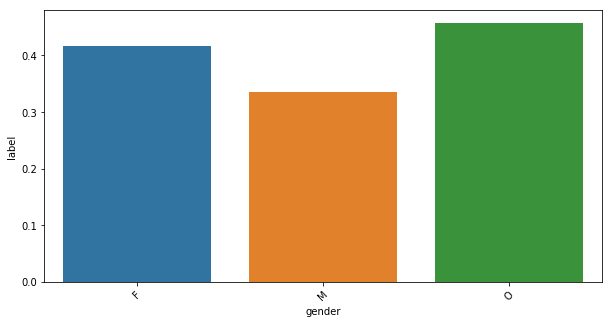

In [50]:
fig,axes=plt.subplots(figsize=(10,5))
gender_data = final_data.groupby('gender',as_index = False)['label'].mean()
plt.xticks(rotation=45)
sns.barplot(data = gender_data,x='gender',y='label')

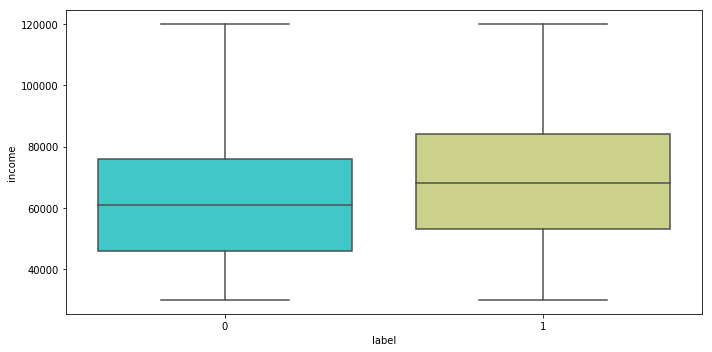

In [51]:
fig,axes=plt.subplots(figsize=(10,5))
sns.boxplot(data=final_data,x='label',y='income',palette='rainbow')
plt.tight_layout()

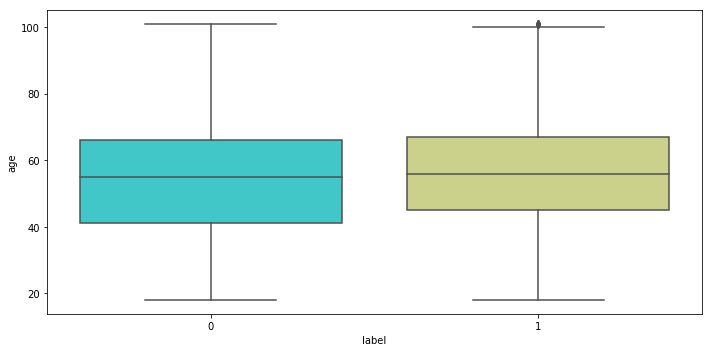

In [52]:
fig,axes=plt.subplots(figsize=(10,5))
sns.boxplot(data=final_data,x='label',y='age',palette='rainbow')
plt.tight_layout()

In [53]:
final_data_copy = final_data.dropna().reset_index(drop = True)

In [54]:
person_group = final_data_copy.groupby('person',as_index = False).agg({'offer_id':lambda x : x.nunique(),
                                                   'gender':lambda x:x.mode()[0],
                                                   'income' : 'max',
                                                   'age' : 'max'})

In [55]:
person_group.head()

,person,offer_id,gender,income,age
0,0009655768c64bdeb2e877511632db8f,5,M,72000.0,33.0
1,0011e0d4e6b944f998e987f904e8c1e5,5,O,57000.0,40.0
2,0020c2b971eb4e9188eac86d93036a77,4,F,90000.0,59.0
3,0020ccbbb6d84e358d3414a3ff76cffd,4,F,60000.0,24.0
4,003d66b6608740288d6cc97a6903f4f0,4,F,73000.0,26.0


In [56]:
person_group['offer_id'].value_counts()

4    5747
3    4375
5    2763
2    1394
6     393
1     148
Name: offer_id, dtype: int64

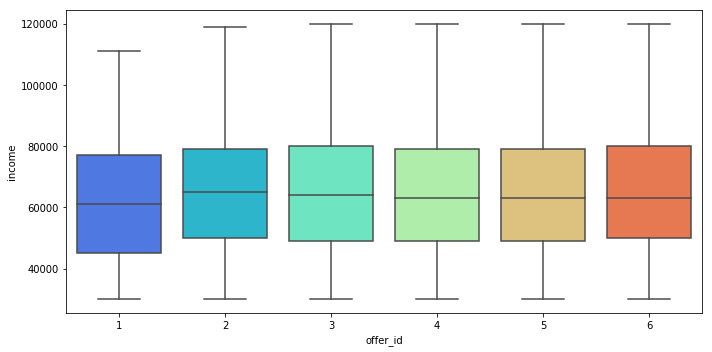

In [57]:
fig,axes=plt.subplots(figsize=(10,5))
sns.boxplot(data=person_group,x='offer_id',y='income',palette='rainbow')
plt.tight_layout()

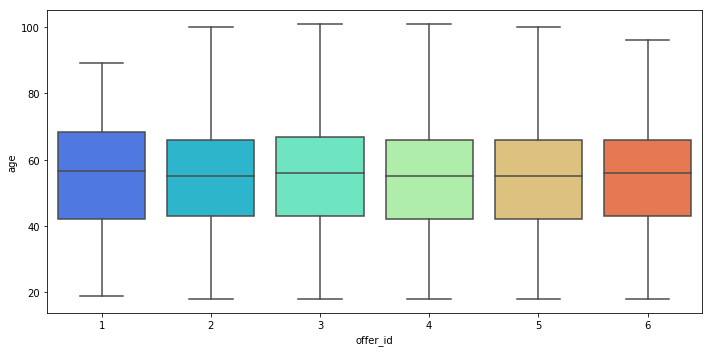

In [58]:
fig,axes=plt.subplots(figsize=(10,5))
sns.boxplot(data=person_group,x='offer_id',y='age',palette='rainbow')
plt.tight_layout()

In [59]:
#creating order data
transaction_data = transcript[transcript['event'] == 'transaction'][['person','value','time']].reset_index(drop = True)

In [60]:
transaction_data.head()

,person,value,time
0,02c083884c7d45b39cc68e1314fec56c,{'amount': 0.8300000000000001},0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,{'amount': 34.56},0
2,54890f68699049c2a04d415abc25e717,{'amount': 13.23},0
3,b2f1cd155b864803ad8334cdf13c4bd2,{'amount': 19.51},0
4,fe97aa22dd3e48c8b143116a8403dd52,{'amount': 18.97},0


In [61]:
transaction_data['amount'] = transaction_data['value'].apply(lambda x: x.get('amount'))

In [73]:
transaction_data['person'].nunique()

16578

In [62]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138953 entries, 0 to 138952
Data columns (total 4 columns):
person    138953 non-null object
value     138953 non-null object
time      138953 non-null int64
amount    138953 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


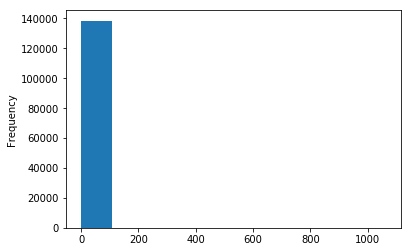

In [63]:
transaction_data['amount'].plot(kind = 'hist')

In [64]:
#number of distinct offers for customer by customer attributes
# calculate transaction features prior to offer recieved time - Number of orders, Number of offers,
# previous offer completed flag, sum of amount, 
# find discrepany in number of person in final_data df. 
# remove data that is not completed and not yet finished from modelling

In [65]:
transaction_data_time = pd.merge(transaction_data,final_data[['person','time']].\
         rename(columns = {'time' : 'time_offer'}),how = 'left',on = 'person')

In [66]:
transaction_data_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527629 entries, 0 to 527628
Data columns (total 5 columns):
person        527629 non-null object
value         527629 non-null object
time          527629 non-null int64
amount        527629 non-null float64
time_offer    527609 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 24.2+ MB


In [67]:
transaction_data_time = transaction_data_time[transaction_data_time['time'] < transaction_data_time['time_offer']].\
        copy().\
        reset_index(drop = True)


In [68]:
transaction_data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218998 entries, 0 to 218997
Data columns (total 5 columns):
person        218998 non-null object
value         218998 non-null object
time          218998 non-null int64
amount        218998 non-null float64
time_offer    218998 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 8.4+ MB


In [69]:
transaction_data_time.head()

,person,value,time,amount,time_offer
0,02c083884c7d45b39cc68e1314fec56c,{'amount': 0.8300000000000001},0,0.83,408.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,{'amount': 34.56},0,34.56,408.0
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,{'amount': 34.56},0,34.56,504.0
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,{'amount': 34.56},0,34.56,336.0
4,54890f68699049c2a04d415abc25e717,{'amount': 13.23},0,13.23,336.0


In [70]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 14 columns):
person              63288 non-null object
offer_id            63288 non-null object
time                63288 non-null int64
label               63288 non-null int64
channels            63288 non-null object
difficulty          63288 non-null int64
duration            63288 non-null int64
offer_type          63288 non-null object
reward              63288 non-null int64
number_channels     63288 non-null int64
age                 55222 non-null float64
became_member_on    55222 non-null float64
gender              55222 non-null object
income              55222 non-null float64
dtypes: float64(3), int64(6), object(5)
memory usage: 9.7+ MB


In [71]:
final_data[['person','time']].drop_duplicates().shape

(63288, 2)

In [72]:
transaction_data_time[['person','time_offer']].drop_duplicates().shape

(46461, 2)

In [74]:
final_data['person'].nunique()

16994

In [ ]:
#person income number of orders number of offers sum of amount
#day vs amount scatter plot

